In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# Measured data

In [47]:
def applyfunc(m):
    """
    Extract values (values are always under 'v'):
    """
    
    d = json.loads(m)
    for k in d.keys():
        if isinstance(d[k], dict):
            d_sub = d[k]
            value = d_sub['v']
            
            #print(f"key: {k}, value: {value}")
            d[k] = value
    return d

In [48]:
file = "trolleberg_20250701.csv"
df_raw = pd.read_csv(file, low_memory=False)
df_raw['m'] = df_raw['m'].apply(applyfunc)
json_expanded = pd.json_normalize(df_raw['m'])

df_telem_1s = pd.concat([df_raw.drop(columns=['h','t','m','folder','dt']), json_expanded], axis=1)
df_telem_1s['DateTime'] = pd.to_datetime(df_telem_1s['loggertimestamp'], unit='s', utc=True)
df_telem_1s = df_telem_1s.drop(columns=['loggertimestamp'])
df_telem_1s = df_telem_1s.set_index('DateTime')

df_telem_1s = df_telem_1s.resample('10s').first().ffill()   # NOTE: tuning, we do not need higher resolution than 10s. Original data is 5s

df_telem_1s = df_telem_1s.resample('1s').first().ffill()
df_telem_1s = df_telem_1s[['active_power', 'available_active']]
df_telem_1s = df_telem_1s.rename(columns={'available_active': 'available_power'})
df_telem_1s['available_power'] = df_telem_1s['available_power'].clip(0, 4550)   # NOTE: tuning, the park never produces above this value.
df_telem_1s = df_telem_1s.dropna()

del df_raw, json_expanded

#df_telem_1s
df_telem_10s = df_telem_1s.resample('10s').first().ffill()
del df_telem_1s

In [49]:
df_telem_10s

,active_power,available_power
DateTime,,
2025-06-05 11:56:20+00:00,1323.77,1095.0
2025-06-05 11:56:30+00:00,1413.95,1134.0
2025-06-05 11:56:40+00:00,1538.23,1256.0
2025-06-05 11:56:50+00:00,1470.65,1304.0
2025-06-05 11:57:00+00:00,1441.74,1399.0
...,...,...
2025-07-01 08:19:40+00:00,73.15,178.0
2025-07-01 08:19:50+00:00,77.51,192.0
2025-07-01 08:20:00+00:00,80.89,192.0


### Forecast data
From databricks SQL query

In [50]:
file_forecasts = "Trolleberg_latest_wind_forecasts_2025_07_01.csv"
df_forec_15min = pd.read_csv(file_forecasts)
df_forec_15min['valid_time_cet'] = pd.to_datetime(df_forec_15min['valid_time_cet'])
df_forec_15min['valid_time_cet'] = df_forec_15min['valid_time_cet'].dt.tz_localize('Europe/Stockholm').dt.tz_convert('UTC')
df_forec_15min = df_forec_15min.rename(columns={"valid_time_cet": "valid_time_utc"})
df_forec_15min = df_forec_15min.set_index('valid_time_utc', drop=False)
df_forec_15min['predicted_power'] = 1000* df_forec_15min['total_predicted_power_mw']
df_forec_15min = df_forec_15min.drop(columns=['fetch_time_cet', 'valid_time_utc', 'predict_horizon_days_cet', 'total_predicted_power_mw'])
start = '2025-06-05 11:30:00'   # Discard forecasts before telemetery logging started
df_forec_15min = df_forec_15min[start:]
df_forec_15min

,predicted_power
valid_time_utc,
2025-06-05 11:30:00+00:00,722.0
2025-06-05 11:45:00+00:00,648.0
2025-06-05 12:00:00+00:00,592.0
2025-06-05 12:15:00+00:00,598.0
2025-06-05 12:30:00+00:00,606.0
...,...
2025-07-01 05:45:00+00:00,0.0
2025-07-01 06:00:00+00:00,0.0
2025-07-01 06:15:00+00:00,0.0


In [51]:
df_forec_10s = df_forec_15min.resample('10s').first().ffill()
df_forec_10s

,predicted_power
valid_time_utc,
2025-06-05 11:30:00+00:00,722.0
2025-06-05 11:30:10+00:00,722.0
2025-06-05 11:30:20+00:00,722.0
2025-06-05 11:30:30+00:00,722.0
2025-06-05 11:30:40+00:00,722.0
...,...
2025-07-01 06:44:20+00:00,0.0
2025-07-01 06:44:30+00:00,0.0
2025-07-01 06:44:40+00:00,0.0


### DSO (sold and bought) data
From Kobes imbalances dashboard

In [52]:
#file_dso = 'trolleberg_sold_vs_produced_20250612.csv'
#df_dso_15min = pd.read_csv(file_dso)
#df_dso_15min = df_dso_15min.set_index(pd.to_datetime(df_dso_15min['ts']))
#df_dso_15min = df_dso_15min.tz_localize('Europe/Stockholm').tz_convert('UTC')
#df_dso_15min = df_dso_15min.drop(columns=['ts'])
#df_dso_15min = df_dso_15min.rename(columns={'sum(sell_vol_kwh)': 'dso_sold_energy', 'sum(production_kwh)': 'dso_produced_energy'})
#df_dso_15min

# OLD Forecasted data
ts
activePower
averageIrradiance
predicted_power_kw

# Make one common df with the right resolution and columns
- 10s sampling time
- 

In [53]:
df = df_telem_10s.merge(df_forec_10s, left_index=True, right_index=True, how='left')

In [54]:
df.head()

,active_power,available_power,predicted_power
DateTime,,,
2025-06-05 11:56:20+00:00,1323.77,1095.0,648.0
2025-06-05 11:56:30+00:00,1413.95,1134.0,648.0
2025-06-05 11:56:40+00:00,1538.23,1256.0,648.0
2025-06-05 11:56:50+00:00,1470.65,1304.0,648.0
2025-06-05 11:57:00+00:00,1441.74,1399.0,648.0


<Axes: xlabel='DateTime'>

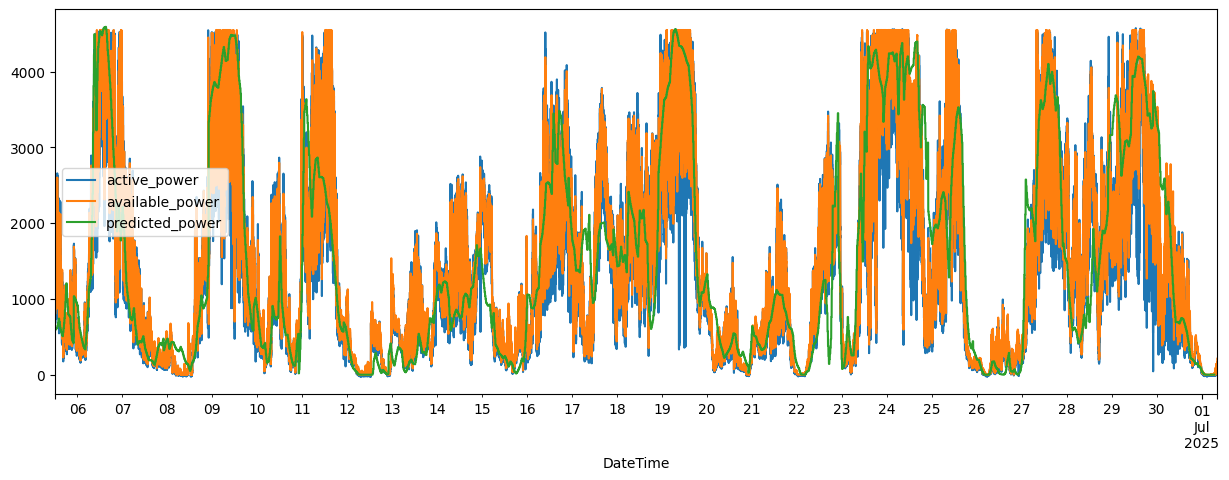

In [55]:
df.plot(figsize=(15, 5)) #, subplots=True, layout=(3, 1), sharex=True)

!!! On the 19th of june we did curtailment tests

In [112]:
# Remove time periods of tests
mask = (df.index < '2025-06-19 08:00:00') | (df.index > '2025-06-19 13:00:00')
df = df[mask]
mask = (df.index < '2025-06-24 11:00:00') | (df.index > '2025-06-24 17:00:00')
df = df[mask]
df.head()

,active_power,available_power,predicted_power,min_predicted_power_per_hour_kw,bid,has_bid
DateTime,,,,,,
2025-06-05 11:00:00+00:00,NaN,NaN,NaN,648.0,0,False
2025-06-05 11:56:20+00:00,1323.77,1095.0,648.0,648.0,0,False
2025-06-05 11:56:30+00:00,1413.95,1134.0,648.0,648.0,0,False
2025-06-05 11:56:40+00:00,1538.23,1256.0,648.0,648.0,0,False
2025-06-05 11:56:50+00:00,1470.65,1304.0,648.0,648.0,0,False


# Find number of biddable hours

Rules:

- Minimum bid size mFRR 1000kW
- Minimum 2000kW available predicted power to have margin.

Heuristic approach:
- It seems like when always risk going down to ~400kW due to clouds. Maybe take this as the bid size given a predicted power of >~1100kW?

In [57]:
# find the minimum predicted power per hour
tmp = df.resample('1h').min()
tmp['min_predicted_power_per_hour_kw'] = tmp['predicted_power']
tmp = tmp.drop(tmp.columns.difference(['ts','min_predicted_power_per_hour_kw']), axis=1)

df = df.merge(tmp, left_index=True, right_index=True, how='outer').ffill()
df.head()


,active_power,available_power,predicted_power,min_predicted_power_per_hour_kw
DateTime,,,,
2025-06-05 11:00:00+00:00,NaN,NaN,NaN,648.0
2025-06-05 11:56:20+00:00,1323.77,1095.0,648.0,648.0
2025-06-05 11:56:30+00:00,1413.95,1134.0,648.0,648.0
2025-06-05 11:56:40+00:00,1538.23,1256.0,648.0,648.0
2025-06-05 11:56:50+00:00,1470.65,1304.0,648.0,648.0


<Axes: xlabel='DateTime'>

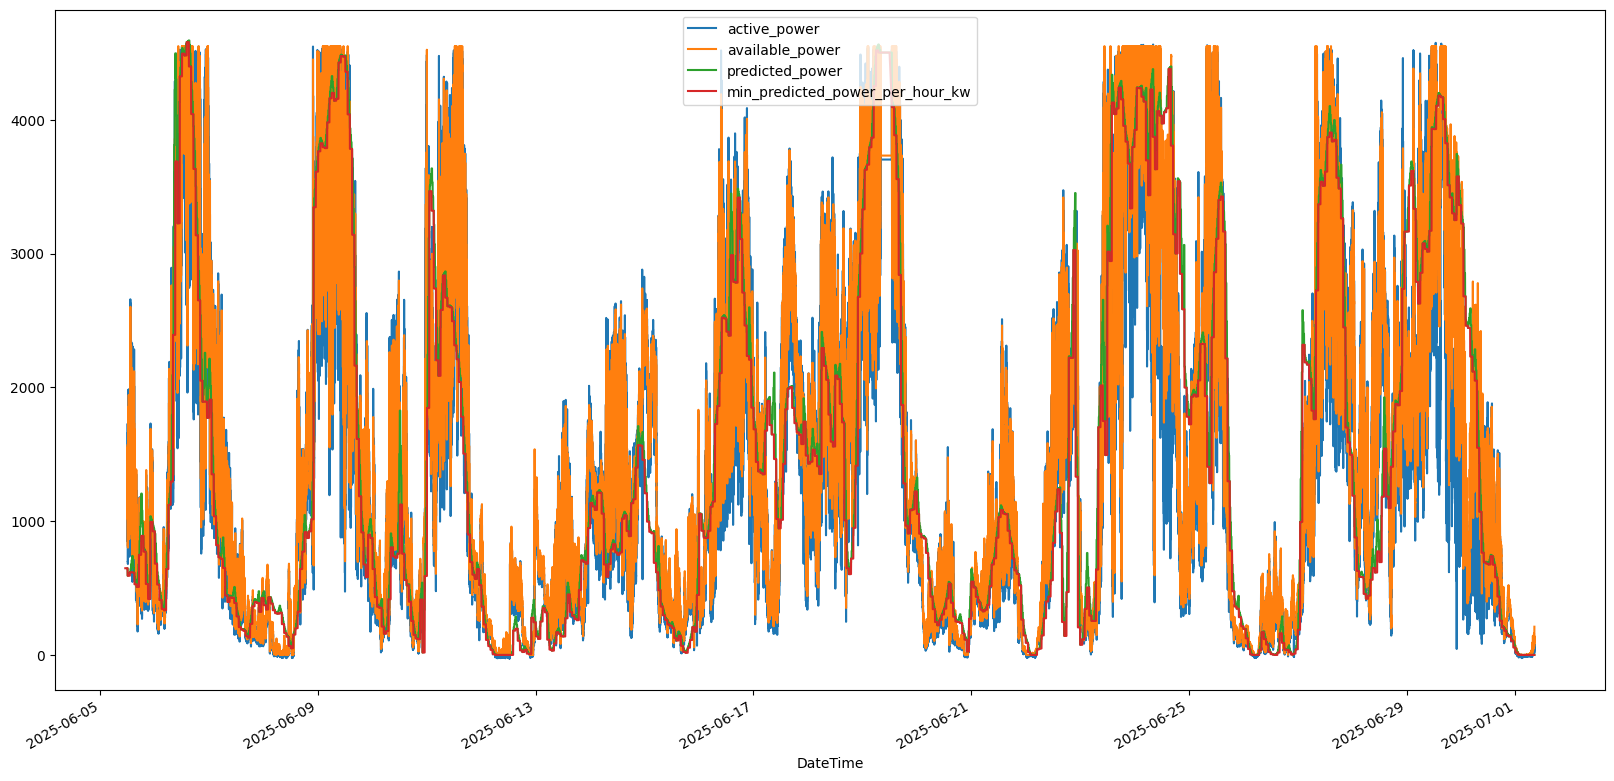

In [58]:
df.plot(figsize=(20,10))

<Axes: xlabel='DateTime'>

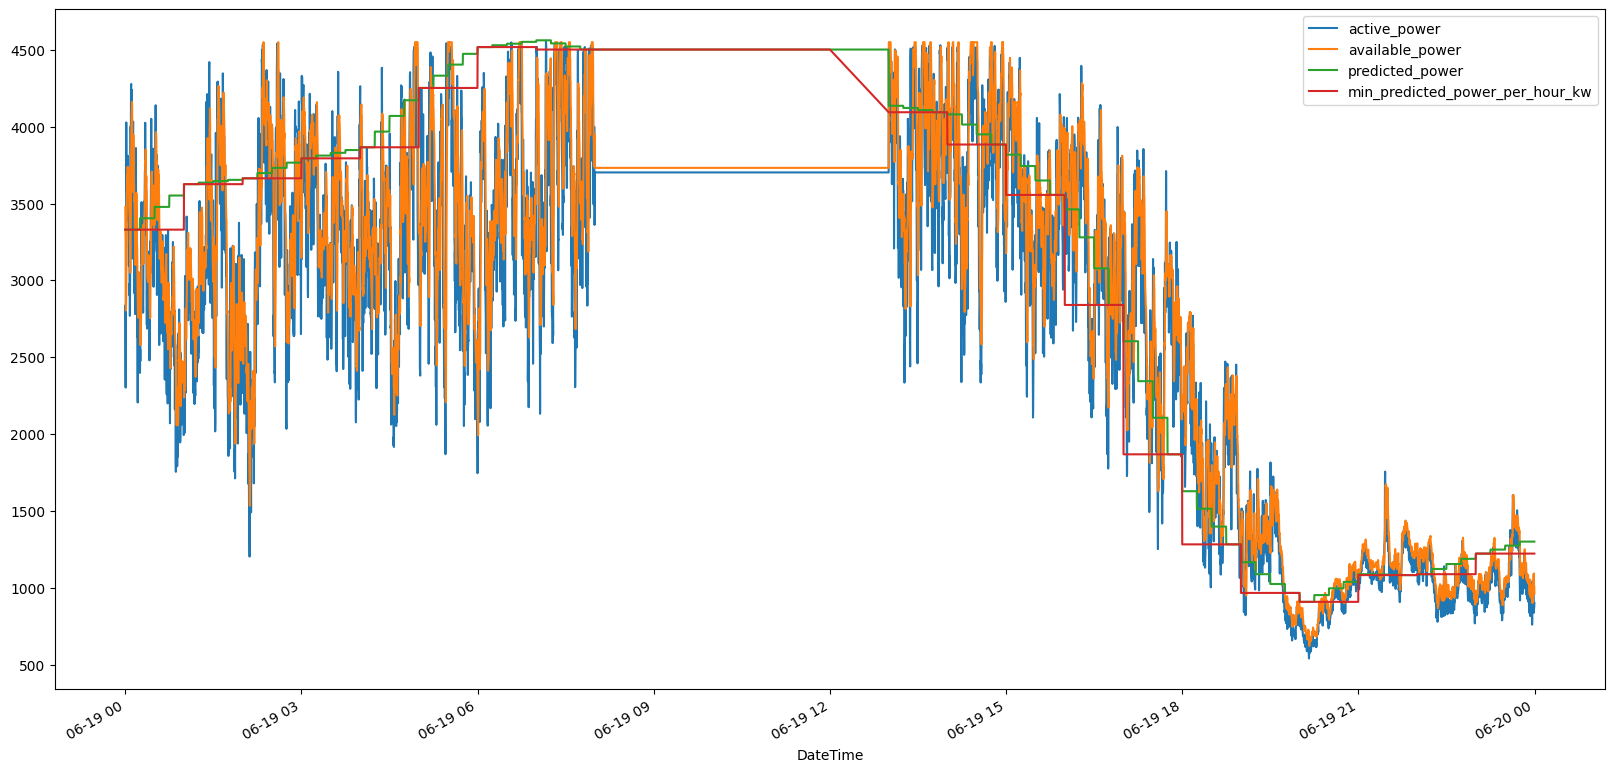

In [59]:
mask = (df.index >= '2025-06-19 00:00:00') & (df.index < '2025-06-20 00:00:00')
df_ = df[mask]
df_.plot(figsize=(20,10))

<Axes: xlabel='DateTime'>

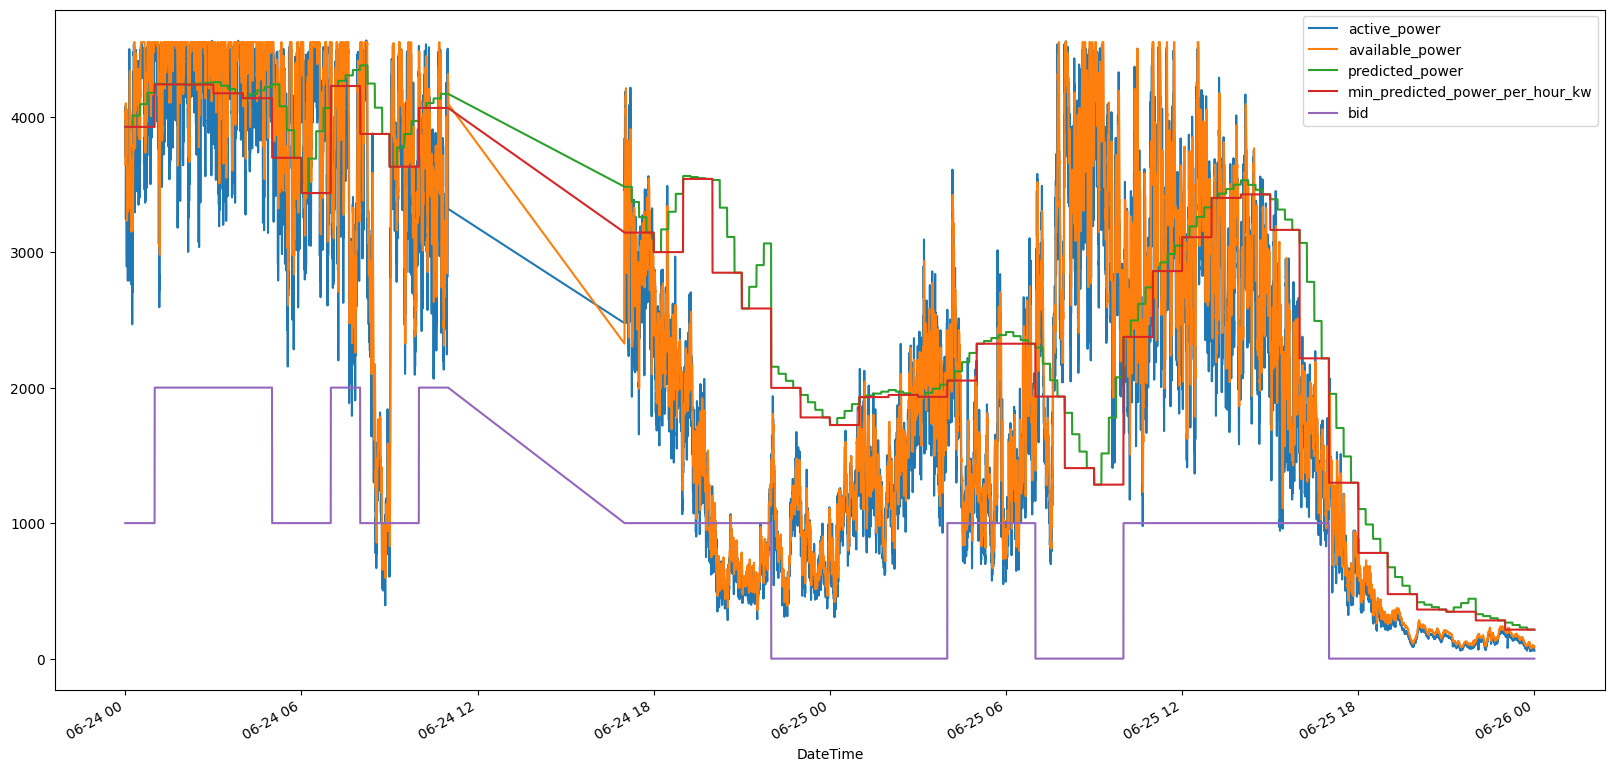

In [113]:
mask = (df.index >= '2025-06-24 00:00:00') & (df.index < '2025-06-26 00:00:00')
df_ = df[mask]
df_.plot(figsize=(20,10))

### Create bids

In [145]:
df['bid'] = 0 # create a new column 'bid' and set it to 0

# Option 1: set the bid to 1000kW if the min predicted power is greater than 2000kW
# 2000kW if the min predicted power is greater than 4000kW
# The hour before and after must also fulfill the condition
df.loc[(df['min_predicted_power_per_hour_kw'] > 2500) &
       (df['min_predicted_power_per_hour_kw'].shift(-6*60) > 2500) &
       (df['min_predicted_power_per_hour_kw'].shift(6*60) > 2500), 'bid'] = 1000
df.loc[(df['min_predicted_power_per_hour_kw'] > 4100) &
       (df['min_predicted_power_per_hour_kw'].shift(-6*60) > 4100) &
       (df['min_predicted_power_per_hour_kw'].shift(6*60) > 4100), 'bid'] = 2000
#df.loc[(df['min_predicted_power_per_hour_kw'] > 4200) &
#       (df['min_predicted_power_per_hour_kw'].shift(-6*60) > 4200) &
#       (df['min_predicted_power_per_hour_kw'].shift(6*60) > 4200), 'bid'] = 3000

# Option 2: set the bid to min predicted power minus 200kW, given that the min predicted power is greater than 1000kW
#df_tot.loc[df_tot['min_predicted_power_per_hour_kw'] > 1000, 'bid'] = df_tot['min_predicted_power_per_hour_kw'] - 200

# Option 3: set the bid to min predicted power minus 500kW, given that the min predicted power is greater than 1000kW
#df_tot.loc[df_tot['min_predicted_power_per_hour_kw'] > 1000, 'bid'] = df_tot['min_predicted_power_per_hour_kw'] - 500

# Option 4: set the bid to min predicted power minus 800kW, given that the min predicted power is greater than 1000kW
#df_tot.loc[df_tot['min_predicted_power_per_hour_kw'] > 1000, 'bid'] = df_tot['min_predicted_power_per_hour_kw'] - 800

# Option 5: set the bid to 400kW, given that the min predicted power is greater than 900kW
#df_tot.loc[df_tot['min_predicted_power_per_hour_kw'] > 900, 'bid'] = 400

# Option 6: If predicted power is greater than 500kW, set the bid to predicted power minus 400kW, with max being 400kW.
#df_tot.loc[df_tot['min_predicted_power_per_hour_kw'] > 700, 'bid'] = np.clip(df_tot['min_predicted_power_per_hour_kw'] - 650, 0, 400)


<Axes: xlabel='DateTime'>

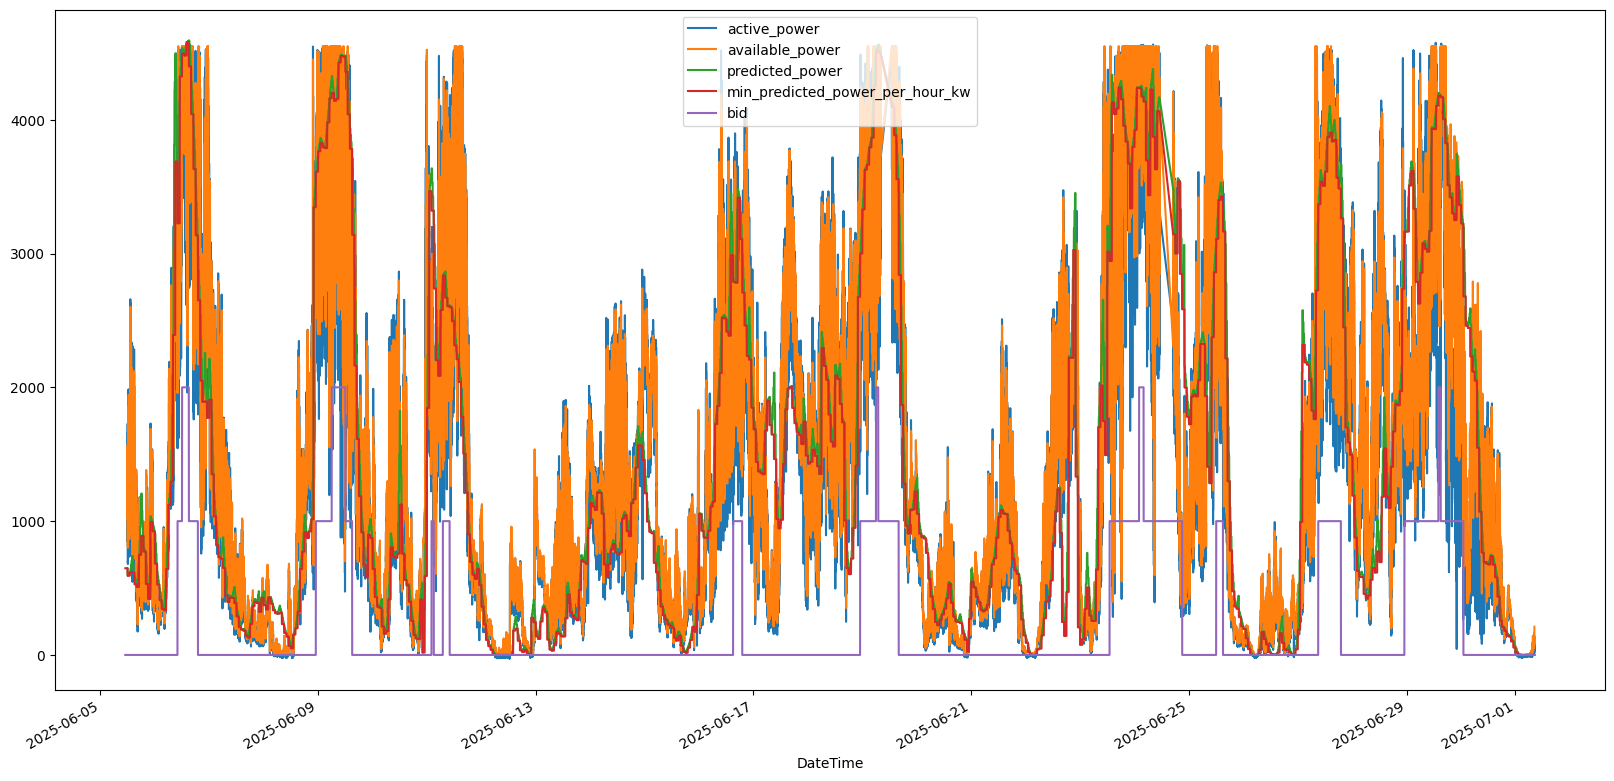

In [146]:
df.plot(figsize=(20, 10))

<Axes: xlabel='DateTime'>

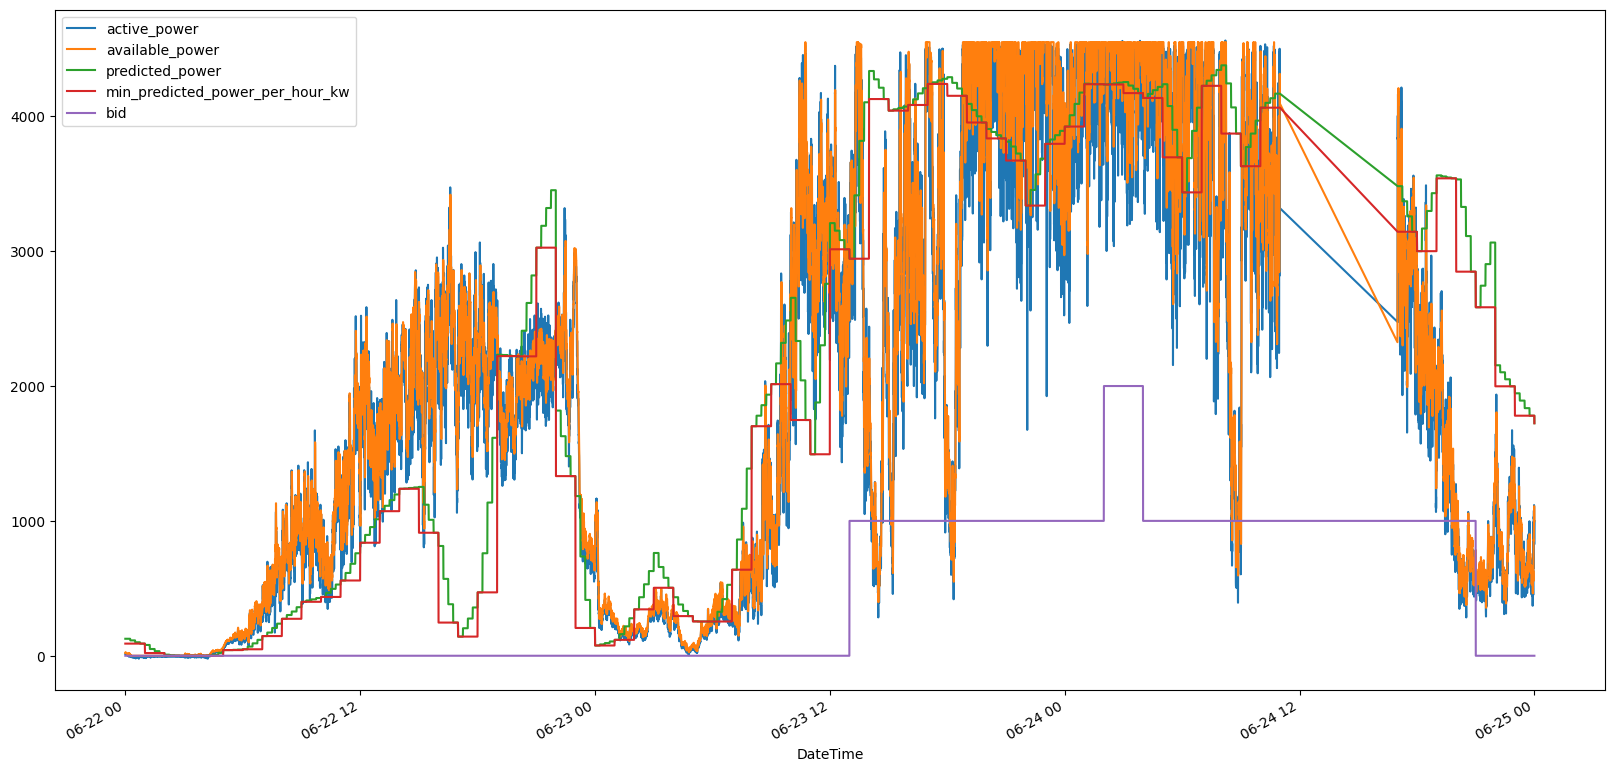

In [147]:
# look at specific time intervals
start = '2025-06-22 00:00:00'
end = '2025-06-25 00:00:00'
mask = (df.index >= start) & (df.index <= end)

title = f'{start} - {end}'
df_ = df[mask]
df_.plot(figsize=(20, 10))

Number of bid hours: 110.0


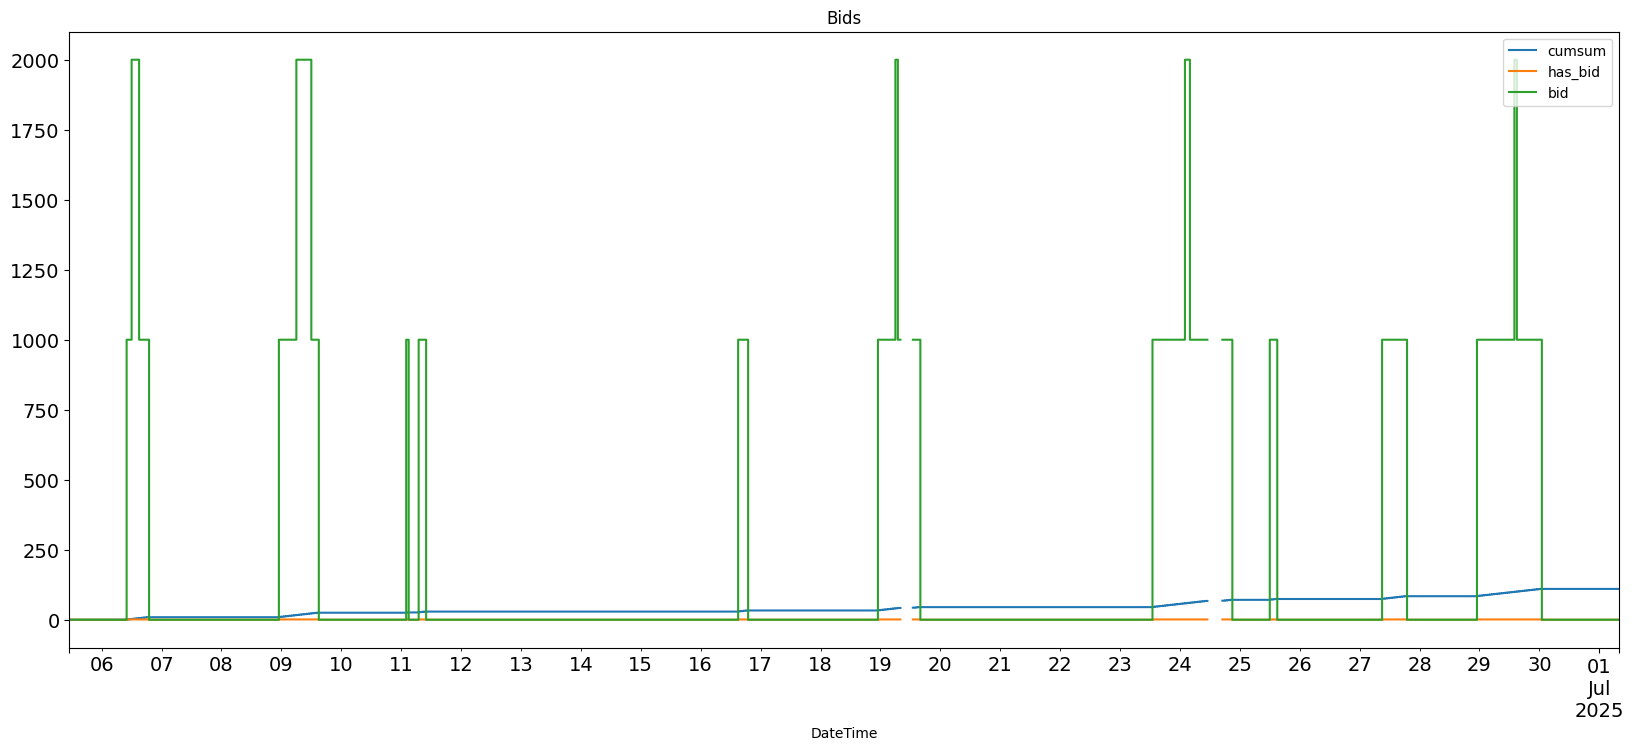

In [148]:
# Count number of bid hours
df['has_bid'] = df['bid'] > 0

df_bids = df.resample('1h').first()
# make a new column where the a counter is incremented by 1 for each hour where has_bid is 1
df_bids['cumsum'] = df_bids['has_bid'].cumsum()
df_bids = df_bids[['cumsum', 'has_bid', 'bid']]
df_bids.plot(figsize=(20, 8), drawstyle="steps-post", title="Bids", fontsize=14)

n_bid_hours = df_bids['cumsum'].iloc[-1]  # Get the last value of the cumulative sum
print(f"Number of bid hours: {n_bid_hours}")
#df_bids

# Accuracy of bids
requirement for mFRR: 90% or more

In [149]:
# Calc accuracy of bids
# Accuracy is defined as the percentage of time where active power is equal to or greater than the bid,
# given that the bid is greater than 0.

min_power = 2*230
condition = df.loc[df['bid'] > 0, 'active_power'] >= df.loc[df['bid'] > 0, 'bid'] + min_power
accuracy = condition.mean() * 100
print(f"Accuracy of bids: {accuracy:.2f}%")

Accuracy of bids: 91.80%


# Export data

In [ ]:
# Export the forecasted data to a csv file, fields:
# Date and time (UTC)
# Forecasted bid capacirty (MW)
# Procured capacity (MW)
# Forecasted power (MW)
df_tot['procured_capacity_mw'] = 0
df_export = df_tot[['ts', 'bid', 'procured_capacity_mw', 'predicted_power_kw_scaled_limited',]]
df_export = df_export.rename(columns={"ts": "date_and_time", "bid": "forecasted_bid_capacity_mw", "predicted_power_kw_scaled_limited": "forecasted_power_mw"})
# Scale from kW to MW
df_export['forecasted_bid_capacity_mw'] = df_export['forecasted_bid_capacity_mw'] / 1000
df_export['forecasted_power_mw'] = df_export['forecasted_power_mw'] / 1000

#df_tot.to_csv("Halmstad_solar_ficticious_bids_2025_05_20.csv", sep=",", decimal=".", index=False)
df_export.to_csv("Halmstad_solar_forecasted_data_2025_05_23.csv", sep=",", decimal=".", index=False)

In [ ]:
df_export.to_csv("Halmstad_solar_forecasted_data_2025_05_23.csv", sep=",", decimal=".", index=False)

# Operational data